<center><h1>Mini Project 7</h1></center>
<br>
<center><font size="5">Name - Spandan Patil</font></center>
<br>
<center><font size="4">Anuran Calls (MFCCs) Data</font></center>

## 1. Multi-class and Multi-Label Classification Using Support Vector Machines

Import packages

In [ ]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import silhouette_score
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
import warnings
warnings.filterwarnings("ignore")

### (a) Download the Anuran Calls (MFCCs) Data Set

In [124]:
# Here we are reading the dataset csv and dropping the last RecordID columns which is not useful.
dataset = pd.read_csv("../data/Anuran Calls (MFCCs)/Frogs_MFCCs.csv")
dataset = dataset.drop('RecordID', axis=1)
dataset.head()

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,...,MFCCs_16,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,Family,Genus,Species
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,...,-0.024017,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038,Leptodactylidae,Adenomera,AdenomeraAndre
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,...,0.012022,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056,Leptodactylidae,Adenomera,AdenomeraAndre
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,...,0.083536,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162,Leptodactylidae,Adenomera,AdenomeraAndre
3,1.0,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,...,-0.050224,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954,Leptodactylidae,Adenomera,AdenomeraAndre
4,1.0,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,...,0.062837,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244,Leptodactylidae,Adenomera,AdenomeraAndre


In [125]:
# Here we are splitting our dataset into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(dataset[dataset.columns[:-3]], dataset[dataset.columns[-3:]], test_size=0.3, random_state=42)
label_lst = ["Family", "Genus", "Species"]

### (b) Train a classifier for each label

#### (i) Research

<ul>
    <li><b>Exact Match:</b> In this, we check if the predicted label set exactly matches the true label set for each instance, thus even if one label is incorrectly predicted the whole set is determined to be incorrect. This method is very strict and thus we miss out on the partially correct predictions.
    <li><b>Hammering Loss:</b> In this, we measures the fraction of labels that are incorrectly predicted (either missed or wrongly assigned), averaged over all labels and samples. Thus, since we are considering partially correct predictions too, so it is a better estimate of accuracy of our model.
</ul>

#### (ii) Train a SVM for each of the labels

In [126]:
# Here we are find the best hyperparameters for our model for each label using 10-fold Cross Validation
best_model = dict()
for label in label_lst:
    param_grid = {
        'C': np.logspace(-1, 3, 10),  
        'gamma': np.logspace(-3, 1, 10)
    }

    # This is the SVM model with Gaussian Kernel (RBF kernel)
    svm = SVC(kernel='rbf')

    # Here we are setting up the grid search with 10-fold cross-validation
    grid_search = GridSearchCV(svm, param_grid, cv=10, n_jobs=-1)

    grid_search.fit(X_train, y_train[label])
    best_params = grid_search.best_params_

    print(f"For the label {label} :")
    print("Best C (penalty) parameter:", best_params['C'])
    print("Best gamma (Gaussian kernel width) parameter:", best_params['gamma'])
    print("---------------------------------------------------------------------------")
    best_model[label] = grid_search

For the label Family :
Best C (penalty) parameter: 5.994842503189409
Best gamma (Gaussian kernel width) parameter: 3.593813663804626
---------------------------------------------------------------------------
For the label Genus :
Best C (penalty) parameter: 5.994842503189409
Best gamma (Gaussian kernel width) parameter: 3.593813663804626
---------------------------------------------------------------------------
For the label Species :
Best C (penalty) parameter: 5.994842503189409
Best gamma (Gaussian kernel width) parameter: 3.593813663804626
---------------------------------------------------------------------------


In [127]:
# Here we are calculating the exact match score and hamming loss for out SVM with best hyperparameters.
y_pred_all = pd.DataFrame(columns=label_lst)
for label in label_lst:
    y_pred = best_model[label].predict(X_test)
    y_pred_all[label] = y_pred

y_test_np = np.array(y_test)
y_pred_all_np = np.array(y_pred_all)

exact_match_score = np.mean(np.all(y_test_np == y_pred_all_np, axis=1))
hamming_loss = np.sum(y_test_np != y_pred_all_np) / (y_test_np.shape[0] * y_test_np.shape[1])

print(f"The Exact Match score is: {exact_match_score:.4f}")
print(f"The Hamming Loss is: {hamming_loss:.4f}")


The Exact Match score is: 0.9856
The Hamming Loss is: 0.0099


#### (iii) Repeat 1(b)ii with L1-penalized SVMs

In [128]:
# Here we are scaling our input features using Standard Scaler.
scaler = StandardScaler()
X_train_standard = scaler.fit_transform(X_train)
X_test_standard = scaler.transform(X_test)

In [129]:
# Here we are find the best hyperparameters for our model for each label using 10-fold Cross Validation
best_model = dict()
for label in label_lst:
    param_grid = {
        'C': np.logspace(-1, 3, 10)
    }

    # This is the Linear SVM model with L-1 Penalty
    svm = LinearSVC(penalty="l1", max_iter=10000)

    # Here we are setting up the grid search with 10-fold cross-validation
    grid_search = GridSearchCV(svm, param_grid, cv=10, n_jobs=-1)

    grid_search.fit(X_train_standard, y_train[label])

    best_params = grid_search.best_params_

    print(f"For the label {label} :")
    print("Best C (penalty) parameter:", best_params['C'])
    print("---------------------------------------------------------------------------")
    best_model[label] = grid_search

For the label Family :
Best C (penalty) parameter: 0.774263682681127
---------------------------------------------------------------------------
For the label Genus :
Best C (penalty) parameter: 16.68100537200059
---------------------------------------------------------------------------
For the label Species :
Best C (penalty) parameter: 16.68100537200059
---------------------------------------------------------------------------


In [130]:
# Here we are calculating the exact match score and hamming loss for out SVM with best hyperparameters.
y_pred_all = pd.DataFrame(columns=label_lst)
for label in label_lst:
    y_pred = best_model[label].predict(X_test_standard)
    y_pred_all[label] = y_pred

y_test_np = np.array(y_test)
y_pred_all_np = np.array(y_pred_all)

exact_match_score = np.mean(np.all(y_test_np == y_pred_all_np, axis=1))
hamming_loss = np.sum(y_test_np != y_pred_all_np) / (y_test_np.shape[0] * y_test_np.shape[1])

print(f"The Exact Match score is: {exact_match_score:.4f}")
print(f"The Hamming Loss is: {hamming_loss:.4f}")


The Exact Match score is: 0.9125
The Hamming Loss is: 0.0570


#### (iv) Repeat 1(b)iii by using SMOTE or any other method for imbalance

In [131]:
# Here we are find the best hyperparameters for our model for each label using 10-fold Cross Validation
best_model = dict()
for label in label_lst:
    param_grid = {
        'model__C': np.logspace(-1, 3, 10)
    }

    # This is the Linear SVM model with L-1 Penalty
    svm = LinearSVC(penalty="l1", max_iter=10000)
    # Here we are creating a pipeleine to first using SMOTE for class imbalance correction and then our SVM model.
    model_pipeline = Pipeline([('sampling', SMOTE(random_state=42)),
                        ('model', svm)])
    # Here we are setting up the grid search with 10-fold cross-validation
    grid_search = GridSearchCV(model_pipeline, param_grid, cv=10, n_jobs=-1)

    grid_search.fit(X_train_standard, y_train[label])

    best_params = grid_search.best_params_

    print(f"For the label {label} :")
    print("Best C (penalty) parameter:", best_params['model__C'])
    print("---------------------------------------------------------------------------")
    
    best_model[label] = grid_search

For the label Family :
Best C (penalty) parameter: 5.994842503189409
---------------------------------------------------------------------------
For the label Genus :
Best C (penalty) parameter: 46.41588833612777
---------------------------------------------------------------------------
For the label Species :
Best C (penalty) parameter: 0.2782559402207124
---------------------------------------------------------------------------


In [132]:
# Here we are calculating the exact match score and hamming loss for out SVM with best hyperparameters.
y_pred_all = pd.DataFrame(columns=label_lst)
for label in label_lst:
    y_pred = best_model[label].predict(X_test_standard)
    y_pred_all[label] = y_pred

y_test_np = np.array(y_test)
y_pred_all_np = np.array(y_pred_all)

exact_match_score = np.mean(np.all(y_test_np == y_pred_all_np, axis=1))
hamming_loss = np.sum(y_test_np != y_pred_all_np) / (y_test_np.shape[0] * y_test_np.shape[1])

print(f"The Exact Match score is: {exact_match_score:.4f}")
print(f"The Hamming Loss is: {hamming_loss:.4f}")


The Exact Match score is: 0.8527
The Hamming Loss is: 0.0769


From the above results we can conclude that the SVM with Gaussian Kernels gives the best results.

## 2. K-Means Clustering on a Multi-Class and Multi-Label Data Set

### (a) Use k-means clustering

In [133]:
# Here we are finding the the best k value for Kmeans clustering using Silhouette Scoring.
k_vals = range(2, 51)
opt_k = None
best_score = 0

# Here we are scaling our input features
scaler = StandardScaler()
X_standard = scaler.fit_transform(dataset[dataset.columns[:-3]])

# Find the best k value form the k list.
for k in k_vals:
    cluster = KMeans(n_clusters=k, random_state=42)
    cluster_labels = cluster.fit_predict(X_standard)
    score = silhouette_score(X_standard, cluster_labels)
    if score > best_score:
        best_score = score
        opt_k = k

print(f"The Optimal Using Silhouette Score is: {opt_k}")


The Optimal Using Silhouette Score is: 5


In [134]:
# Here we are getting the cluster_ids for each of the samples/
cluster = KMeans(n_clusters=opt_k, random_state=42)
cluster.fit(X_standard)
cluster_lbls_ids = cluster.labels_

### (b) Determine which family is the majority

In [135]:
# Here we are finding the majority labels for each cluster

# Getting the true labels for each sample.
true_lbls = dataset[dataset.columns[-3:]]

# Prepare a DataFrame to store majority label for each cluster
major_lbls = pd.DataFrame(index=range(opt_k), columns=true_lbls.columns)

for cluster_id in range(opt_k):
    # Here we are finding indices of samples in the current cluster
    cluster_idx = (cluster_lbls_ids == cluster_id).nonzero()[0]

    # Her we are extracting the subset of true labels corresponding to this cluster
    cluster_lbls = true_lbls.iloc[cluster_idx]

    for column in true_lbls.columns:
        most_common = cluster_lbls[column].mode().iloc[0]
        major_lbls.at[cluster_id, column] = most_common

major_lbls

,Family,Genus,Species
0,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
1,Hylidae,Hypsiboas,HypsiboasCinerascens
2,Leptodactylidae,Adenomera,AdenomeraAndre
3,Leptodactylidae,Adenomera,AdenomeraAndre
4,Hylidae,Hypsiboas,HypsiboasCordobae


### (c) Calculate the average Hamming distance, Hamming score, and Hamming loss

In [138]:
pred_lbls = np.zeros_like(true_lbls, dtype=object)

# Here For each sample assigning the major label for that sample cluster
for i, cluster_id in enumerate(cluster_lbls_ids):
    pred_lbls[i] = major_lbls.loc[cluster_id].values

pred_lbls = pd.DataFrame(pred_lbls, columns=true_lbls.columns)

# Here we are computing Hamming Distance per sample
ham_dist = (true_lbls.values != pred_lbls.values).sum(axis=1)

# Here we are computing Hamming Loss (fraction of incorrect labels)
total_labels = np.prod(true_lbls.shape)
total_mismatches = ham_dist.sum()
ham_loss_val = total_mismatches / total_labels

# Here we are computing Hamming Score (average per-sample label accuracy)
corr = (true_lbls.values == pred_lbls.values).sum(axis=1)
ham_scores = corr / true_lbls.shape[1]
avg_ham_score = np.mean(ham_scores)


print(f"average_hamming_distance: {np.mean(ham_dist)}")
print(f"average_hamming_score: {np.mean(ham_scores)}")
print(f"hamming_loss: {ham_loss_val}")


average_hamming_distance: 0.7457956914523975
average_hamming_score: 0.7514014361825343
hamming_loss: 0.24859856381746584


### Monte-Carlo Simulation:

In [140]:
ham_dist_lst = []
for idx in range(1, 52):
    print(f"The index of interation: {idx}")
    print("")
    print("")
    # Here we are finding the the best k value for Kmeans clustering using Silhouette Scoring.
    k_vals = range(2, 51)
    opt_k = None
    best_score = 0

    # Here we are scaling our input features
    scaler = StandardScaler()
    X_standard = scaler.fit_transform(dataset[dataset.columns[:-3]])

    # Find the best k value form the k list.
    for k in k_vals:
        cluster = KMeans(n_clusters=k, random_state=idx)
        cluster_labels = cluster.fit_predict(X_standard)
        score = silhouette_score(X_standard, cluster_labels)
        if score > best_score:
            best_score = score
            opt_k = k

    print(f"The Optimal Using Silhouette Score is: {opt_k}")
    print("")
    print("")
    # Here we are getting the cluster_ids for each of the samples/
    cluster = KMeans(n_clusters=opt_k, random_state=42)
    cluster.fit(X_standard)
    cluster_lbls_ids = cluster.labels_

    # Here we are finding the majority labels for each cluster

    # Getting the true labels for each sample.
    true_lbls = dataset[dataset.columns[-3:]]

    # Prepare a DataFrame to store majority label for each cluster
    major_lbls = pd.DataFrame(index=range(opt_k), columns=true_lbls.columns)

    for cluster_id in range(opt_k):
        # Here we are finding indices of samples in the current cluster
        cluster_idx = (cluster_lbls_ids == cluster_id).nonzero()[0]

        # Her we are extracting the subset of true labels corresponding to this cluster
        cluster_lbls = true_lbls.iloc[cluster_idx]

        for column in true_lbls.columns:
            most_common = cluster_lbls[column].mode().iloc[0]
            major_lbls.at[cluster_id, column] = most_common

    print("The majority labels for each cluster are:")
    print("")
    print(major_lbls)
    print("")
    print("")
    pred_lbls = np.zeros_like(true_lbls, dtype=object)

    # Here For each sample assigning the major label for that sample cluster
    for i, cluster_id in enumerate(cluster_lbls_ids):
        pred_lbls[i] = major_lbls.loc[cluster_id].values

    pred_lbls = pd.DataFrame(pred_lbls, columns=true_lbls.columns)

    # Here we are computing Hamming Distance per sample
    ham_dist = (true_lbls.values != pred_lbls.values).sum(axis=1)

    # Here we are computing Hamming Loss (fraction of incorrect labels)
    total_labels = np.prod(true_lbls.shape)
    total_mismatches = ham_dist.sum()
    ham_loss_val = total_mismatches / total_labels

    # Here we are computing Hamming Score (average per-sample label accuracy)
    corr = (true_lbls.values == pred_lbls.values).sum(axis=1)
    ham_scores = corr / true_lbls.shape[1]
    avg_ham_score = np.mean(ham_scores)

    print("")
    print("")
    print(f"average_hamming_distance: {np.mean(ham_dist)}")
    print(f"average_hamming_score: {np.mean(ham_scores)}")
    print(f"hamming_loss: {ham_loss_val}")
    print("")
    print("-------------------------------------------------------------------------------------------------")
    print("")
    print("")
    ham_dist_lst.append(ham_dist)

The index of interation: 1


The Optimal Using Silhouette Score is: 2


The majority labels for each cluster are:

            Family      Genus                 Species
0  Leptodactylidae  Adenomera  AdenomeraHylaedactylus
1          Hylidae  Hypsiboas       HypsiboasCordobae




average_hamming_distance: 0.8940931202223766
average_hamming_score: 0.7019689599258745
hamming_loss: 0.29803104007412556

-------------------------------------------------------------------------------------------------


The index of interation: 2


The Optimal Using Silhouette Score is: 2


The majority labels for each cluster are:

            Family      Genus                 Species
0  Leptodactylidae  Adenomera  AdenomeraHylaedactylus
1          Hylidae  Hypsiboas       HypsiboasCordobae




average_hamming_distance: 0.8940931202223766
average_hamming_score: 0.7019689599258745
hamming_loss: 0.29803104007412556

----------------------------------------------------------------------------------------------

In [141]:
print(f"The average Hamming distance over 50 Monte Carlo Simulations is: {np.mean(ham_dist_lst)}")

The average Hamming distance over 50 Monte Carlo Simulations is: 0.736172995953072


## 3. ISLR 12.6.2

In [142]:
dissimilarity_matrix = np.array([[0.0, 0.3, 0.4, 0.7], [0.3, 0.0, 0.5, 0.8], [0.4, 0.5, 0.0, 0.45],[0.7, 0.8, 0.45, 0.0]])
dissimilarity_vector = squareform(dissimilarity_matrix)

### a) Dendrogram with Complete Linkage

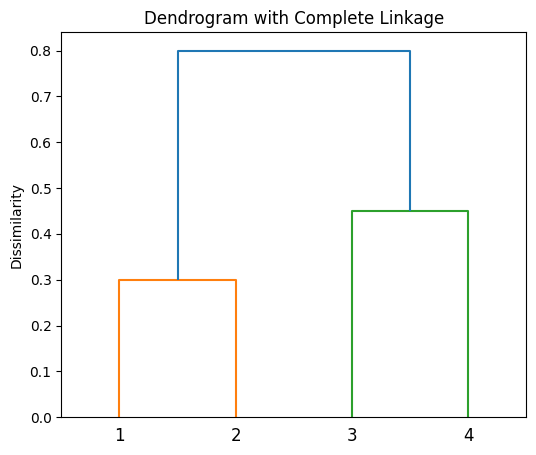

In [143]:
Z_complete = sch.linkage(dissimilarity_vector, method='complete')

plt.figure(figsize=(6, 5))
sch.dendrogram(Z_complete, labels=[1, 2, 3, 4])
plt.title("Dendrogram with Complete Linkage")
plt.ylabel("Dissimilarity")
plt.show()

### b) Dendrogram with Single Linkage

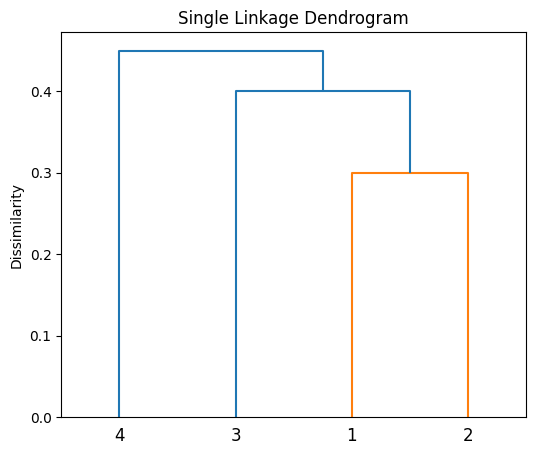

In [144]:
Z_single = sch.linkage(dissimilarity_vector, method='single')

plt.figure(figsize=(6, 5))
sch.dendrogram(Z_single, labels=[1, 2, 3, 4])
plt.title("Single Linkage Dendrogram")
plt.ylabel("Dissimilarity")
plt.show()

### c) Cut Complete Linkage Dendrogram into 2 Clusters

The observations are divided into following 2 cluster:
<ul>
    <li>[1, 2]
    <li>[3, 4]
</ul>

### d) Cut Single Linkage Dendrogram to Form 2 Clusters

The observations are divided into following 2 cluster:
<ul>
    <li>[1, 2, 3]
    <li>[4]
</ul>

### e) Equivalent Dendrogram with Reordered Branches

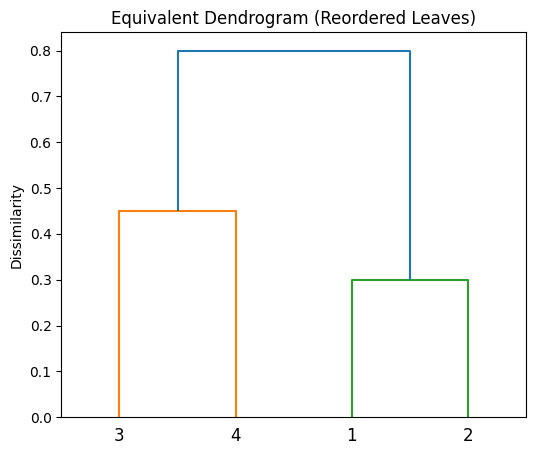

In [145]:
Z_swapped = Z_complete.copy()
Z_swapped[2, 0], Z_swapped[2, 1] = Z_swapped[2, 1], Z_swapped[2, 0]

plt.figure(figsize=(6, 5))
sch.dendrogram(Z_swapped, labels=[1, 2, 3, 4])

plt.title("Equivalent Dendrogram (Reordered Leaves)")
plt.ylabel("Dissimilarity")
plt.show()